# <font color='red' style='font-size: 25px;'>Interpretação de Ensaio Triaxial Drenado</font>

# <font color='red' style='font-size: 25px;'>Consolidated Drained Triaxial Test - CID </font>
<hr style='border: 2px solid red;'>

Este script recebe os arquivos de dados de laboratório referentes à moldagem, saturação (percolação e contrapressão), adensamento isotrópico e da fase de cisalhamento. Processa os cálculos necessários à interpretação do ensaio e à definição dos parâmetros de resistência do solo. São apresentadas as curvas: tensão versus deformação axial, deformação volumétrica versus deformação axial, poropressão versus deformação axial, trajetória de tensões, envoltórias de resistência (máxima tensão de desvio) e o gráfico com os Circulos de Mohr.

Para cada corpo de prova do ensaio, devem ser preparados os arquivos de dados. São fornecidos: arquivo com os dados da fase de moldagem e arquivo com dados da fase de cisalhamento, ambos no formato .csv. Após o processamento, o script gera os arquivos com os dados calculados, que podem ser exportados para o Excel. Para todas as fases do ensaio, são geradas tabelas formatadas, constantes no script, que podem ser copiadas e levadas para os relatórios técnicos.


Para o traçado da envoltória dos Círculos de Mohr, deverão ser fornecidos os valores de `c (coesão)` e `phi (ângulo de atrito)` até ajustar a melhor reta tangente aos círculos de Mohr. Deverá, também, ser fornecido o valor de `sig` para ajustar a envoltória no intervalo de tensões do ensaio. As instruções estão no item Traçado da Envoltória de Mohr-Coulomb.

`Preparado por: Eng. José Mário Queiroga Mafra`

Outubro/2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# <font color='green' style='font-size: 20px;'>Funções utilizadas no script</font>
<hr style='border: 2px solid green;'>

In [2]:
def moldagem_cp(df, label=None):
    
    '''Esta função recebe os dados de moldagem do corpo de prova e processa os cálculos complementares'''
    
    df = df.copy()
    df['Área_Inicial (cm²)'] = (np.pi * df['Diâmetro (cm)'] ** 2 / 4).round(2)  
    df['Volume_Inicial (cm³)'] = (df['Área_Inicial (cm²)'] * df['Altura (cm)']).round(2)
    df['Massa Esp Úmida (g/cm³)'] = (df['Massa Úmida (g)'] / df['Volume_Inicial (cm³)']).round(2)
    df['Massa Seca (g)'] = (df['Massa Úmida (g)'] / (1 + (df['Umidade (%)'] / 100))).round(2)
    df['Massa Esp Seca (g/cm³)']= (df['Massa Seca (g)'] / df['Volume_Inicial (cm³)']).round(2)
    df['Peso Esp Sólidos (kN/m³)'] = (df['Gs'] * df['Peso Esp Água (kN/m³)']).round(2)
    df['Peso Esp Seco (kN/m³)'] = ((df['Massa Seca (g)'] / df['Volume_Inicial (cm³)']) * df['Peso Esp Água (kN/m³)']).round(2)
    df['Índice de Vazios'] = ((df['Peso Esp Sólidos (kN/m³)'] / df['Peso Esp Seco (kN/m³)']) - 1).round(3)
    df['Saturação (%)'] = (df['Peso Esp Sólidos (kN/m³)'] * df['Umidade (%)'] / (df['Índice de Vazios'] * df['Peso Esp Água (kN/m³)'])).round(2)
    
    X = df[['Área_Inicial (cm²)','Volume_Inicial (cm³)','Massa Esp Úmida (g/cm³)','Massa Seca (g)',
           'Massa Esp Seca (g/cm³)','Peso Esp Sólidos (kN/m³)','Peso Esp Seco (kN/m³)','Índice de Vazios',
           'Saturação (%)']]
  
    if label:
        y = df[label]
        return X,y
    return X

In [3]:
def saturacao_percolacao(df, data_1):
    
    '''Esta função recebe os dados da fase de saturação do corpo de prova por percolação, processa os cálculos
       complementares e retorna um dataframe com o resumo dos dados'''
        
    linhas_1 = ['Há Variação de Volume ?','Valor da Variação de Volume','Volume Final do CP (cm³)','Massa Esp Seca (g/cm³)','Índice de Vazios após Percolação', 'Saturação']
   

    X = pd.DataFrame(data=data_1,index=linhas_1)
    return X

In [4]:
def saturacao_contrapressao(df, data_2):
    
    '''Esta função recebe os dados da fase de saturação do corpo de prova por contrapressão, processa os cálculos
       complementares e retorna um dataframe com o resumo dos dados'''
   
    linhas_2 = ['Há Variação de Volume ?','Valor da Variação de Volume','Volume Final do CP (cm³)','Massa Esp Seca (g/cm³)','Índice de Vazios após Saturação', 'Saturação', 'Contra pressão final (kPa)','Parâmetro B']
    
    X = pd.DataFrame(data=data_2,index=linhas_2)  
    
    return X

In [5]:
def adensamento(df,Variação_de_Volume):
    
    '''Esta função recebe os dados de adensamento do corpo de prova, processa os cálculos complementares 
       e retorna um dataframe com o resumo dos dados de adensamento.'''
    
    
    Volume_final = df['Volume_Inicial (cm³)'][0] - Variação_de_Volume
    Massa_Esp_Seca_Final = df['Massa Seca (g)'][0] / Volume_final
    Variação_de_Altura = df['Altura (cm)'][0] * Variação_de_Volume / (3 * df['Volume_Inicial (cm³)'][0])
    Altura_Final = df['Altura (cm)'][0] - Variação_de_Altura
    Área_Final  = Volume_final  / Altura_Final
    Índice_de_Vazios_após_Adensamento = (df['Gs'][0]/ Massa_Esp_Seca_Final) - 1



    linhas_3 = ['Há Variação de Volume ?','Valor da Variação de Volume (cm³)',
                'Volume Final do CP (cm³)',
                'Massa Esp Seca Final (g/cm³)','Variação de altura (cm)', 'Altura final do CP (cm)','Área Final (cm²)',
                'Índice de Vazios após Adensamento']

    data_3 = {'Valores Calculados':['Sim', Variação_de_Volume, Volume_final,Massa_Esp_Seca_Final,
                                    Variação_de_Altura, Altura_Final,Área_Final,Índice_de_Vazios_após_Adensamento]}


    Y = pd.DataFrame(data=data_3,index=linhas_3)
    return Y

In [6]:
def deformacao_percent(df):
    
    '''Esta função recebe dados de deformação axial e deformação volumétrica do arquivo de cisalhamento do corpo
       de prova e retorna as deformações percentuais, Sigma_d e Sigma_3 '''
    
    df['Deform_axial'] = df['Deform_axial'] * 100
    df['Deform_Vol']= df['Deform_Vol'] * 100
    df.rename(columns={'Deform_axial': "Deform_axial_(%)", 'Deform_Vol': "Deform_Vol_(%)"}, inplace=True)

    return df

In [7]:
def cisalhamento(df, label=None):
    
    '''Esta função recebe dados de cisalhamento do corpo de prova, processa cálculos complementares e retorna
       um dataframe com o resumo dos dados.'''
    
    df = df.copy()
    df['Sigma_1_(kPa)'] = df['Sigma_d_(kPa)'] + df['Sigma_3_(kPa)']
    df["Sigma'_1_(kPa)"] = df['Sigma_1_(kPa)']
    df["Sigma3'_(kPa)"] = df['Sigma_3_(kPa)']
    df["Sigma'_1/Sigma'_3"] = (df["Sigma'_1_(kPa)"] / df["Sigma3'_(kPa)"]).round(2)
    df['t']= (df['Sigma_1_(kPa)'] - df['Sigma_3_(kPa)']) /2
    df['s'] = (df['Sigma_1_(kPa)'] + df['Sigma_3_(kPa)']) / 2
    df["s'"] = (df["Sigma'_1_(kPa)"] + df["Sigma3'_(kPa)"]) / 2
    df['q'] = df['Sigma_d_(kPa)']
    df['p'] = (df['Sigma_1_(kPa)'] + 2 * df['Sigma_3_(kPa)']) / 3
    df["p'"] = (df["Sigma'_1_(kPa)"] + 2 * df["Sigma3'_(kPa)"])/3

    Z = df[['Sigma_1_(kPa)',"Sigma'_1_(kPa)","Sigma3'_(kPa)","Sigma'_1/Sigma'_3",'t','s',"s'",'q','p',"p'"]]

    if label:
            w = df[label]
            return Z,w
    return Z

### 1. CORPO DE PROVA CP-1  50 kPa

In [8]:
moldagem = pd.read_csv('moldagem_cp_1.csv',sep=';')
moldagem

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³)
0,8.078,3.543,165.5,8.1,3.12,9.81


Moldagem

In [9]:
# Chamando a função moldagem_cp

X, y = moldagem_cp(moldagem ,label= ['Altura (cm)','Diâmetro (cm)','Massa Úmida (g)','Umidade (%)','Gs','Peso Esp Água (kN/m³)'])

df_final = pd.concat([y,X],axis=1)

In [10]:
df_final
df_final.rename(index={0: 'Valores'}, inplace=True)
df_final

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³),Área_Inicial (cm²),Volume_Inicial (cm³),Massa Esp Úmida (g/cm³),Massa Seca (g),Massa Esp Seca (g/cm³),Peso Esp Sólidos (kN/m³),Peso Esp Seco (kN/m³),Índice de Vazios,Saturação (%)
Valores,8.078,3.543,165.5,8.1,3.12,9.81,9.86,79.65,2.08,153.1,1.92,30.61,18.86,0.623,40.57


In [11]:
# Tabela de Moldagem do corpo de prova CP_1

df_final.T.round(2)


,Valores
Altura (cm),8.08
Diâmetro (cm),3.54
Massa Úmida (g),165.50
Umidade (%),8.10
Gs,3.12
Peso Esp Água (kN/m³),9.81
Área_Inicial (cm²),9.86
Volume_Inicial (cm³),79.65
Massa Esp Úmida (g/cm³),2.08
Massa Seca (g),153.10


Saturação

In [12]:
# Chamando a função saturacao_percolacao

saturacao_percolacao(df_final, data_1 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                               df_final['Massa Esp Seca (g/cm³)'][0], 
                                                               df_final['Índice de Vazios'][0],
                                                               df_final['Saturação (%)'][0]]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),79.65
Massa Esp Seca (g/cm³),1.92
Índice de Vazios após Percolação,0.623
Saturação,40.57


In [13]:
# Chamando a função saturacao_contrapressao

saturacao_contrapressao(df_final, data_2 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                                  df_final['Massa Esp Seca (g/cm³)'][0],
                                                                  df_final['Índice de Vazios'][0],
                                                                  df_final['Saturação (%)'][0], 400, 0.957]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),79.65
Massa Esp Seca (g/cm³),1.92
Índice de Vazios após Saturação,0.623
Saturação,40.57
Contra pressão final (kPa),400
Parâmetro B,0.957


Adensamento

In [14]:
# Chamando a função adensamento

adensamento(df_final,0.7)

,Valores Calculados
Há Variação de Volume ?,Sim
Valor da Variação de Volume (cm³),0.7
Volume Final do CP (cm³),78.95
Massa Esp Seca Final (g/cm³),1.939202
Variação de altura (cm),0.023664
Altura final do CP (cm),8.054336
Área Final (cm²),9.802174
Índice de Vazios após Adensamento,0.608909


Cisalhamento

In [15]:
cp_1 = pd.read_csv('cisalhamento_cp1.csv', sep=';')
cp_1.head()

,Deform_axial,Deform_Vol,Sigma_d_(kPa),Sigma_3_(kPa)
0,0.000000,0.000000,0.0,50
1,0.001003,0.001844,110.0,50
2,0.001906,0.001787,123.8,50
3,0.002909,0.002128,135.9,50
4,0.003811,0.002355,148.5,50


In [16]:
# Chamando a função deformacao_percent

deformacao_percent(cp_1)

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.000000,0.000000,0.0,50
1,0.100294,0.184409,110.0,50
2,0.190558,0.178735,123.8,50
3,0.290852,0.212780,135.9,50
4,0.381117,0.235476,148.5,50
...,...,...,...,...
70,19.136065,-3.499617,151.2,50
71,19.436947,-3.522313,150.4,50
72,19.737828,-3.542172,150.0,50
73,20.038710,-3.584728,150.0,50


In [17]:
# Chamando a função cisalhamento

Z, w = cisalhamento(cp_1 ,label= ['Deform_axial_(%)','Deform_Vol_(%)','Sigma_d_(kPa)','Sigma_3_(kPa)'])

In [18]:
df_final = pd.concat([w,Z],axis=1)

In [19]:
df_final.head()

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.000000,0.000000,0.0,50,50.0,50.0,50,1.00,0.00,50.00,50.00,0.0,50.000000,50.000000
1,0.100294,0.184409,110.0,50,160.0,160.0,50,3.20,55.00,105.00,105.00,110.0,86.666667,86.666667
2,0.190558,0.178735,123.8,50,173.8,173.8,50,3.48,61.90,111.90,111.90,123.8,91.266667,91.266667
3,0.290852,0.212780,135.9,50,185.9,185.9,50,3.72,67.95,117.95,117.95,135.9,95.300000,95.300000
4,0.381117,0.235476,148.5,50,198.5,198.5,50,3.97,74.25,124.25,124.25,148.5,99.500000,99.500000


#### CP1_50 - Tabela Preparada para Traçado dos Gráficos e salvada no arquivo cp1_50_calculado

In [20]:
df_final.to_csv('cp1_50_calculado.csv', index=False)

### 2.  CORPO DE PROVA CP-2 100 kPa

In [21]:
moldagem = pd.read_csv('moldagem_cp_2.csv',sep=';')
moldagem

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³)
0,8.06,3.567,161.48,8.6,3.12,9.81


Moldagem

In [22]:
X, y = moldagem_cp(moldagem ,label= ['Altura (cm)','Diâmetro (cm)','Massa Úmida (g)','Umidade (%)','Gs','Peso Esp Água (kN/m³)'])

df_final = pd.concat([y,X],axis=1)

In [23]:
df_final
df_final.rename(index={0: 'Valores'}, inplace=True)
df_final

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³),Área_Inicial (cm²),Volume_Inicial (cm³),Massa Esp Úmida (g/cm³),Massa Seca (g),Massa Esp Seca (g/cm³),Peso Esp Sólidos (kN/m³),Peso Esp Seco (kN/m³),Índice de Vazios,Saturação (%)
Valores,8.06,3.567,161.48,8.6,3.12,9.81,9.99,80.52,2.01,148.69,1.85,30.61,18.12,0.689,38.95


In [24]:
# Tabela de Moldagem do corpo de prova CP_2

df_final.T.round(2)

,Valores
Altura (cm),8.06
Diâmetro (cm),3.57
Massa Úmida (g),161.48
Umidade (%),8.60
Gs,3.12
Peso Esp Água (kN/m³),9.81
Área_Inicial (cm²),9.99
Volume_Inicial (cm³),80.52
Massa Esp Úmida (g/cm³),2.01
Massa Seca (g),148.69


Saturação

In [25]:
# Chamando a função saturacao_percolacao

saturacao_percolacao(df_final, data_1 = {'Valores Calculados':['Sim', 0, df_final['Volume_Inicial (cm³)'][0],
                                                               df_final['Massa Esp Seca (g/cm³)'][0],
                                                               df_final['Índice de Vazios'][0],
                                                               df_final['Saturação (%)'][0]]})

,Valores Calculados
Há Variação de Volume ?,Sim
Valor da Variação de Volume,0
Volume Final do CP (cm³),80.52
Massa Esp Seca (g/cm³),1.85
Índice de Vazios após Percolação,0.689
Saturação,38.95


In [26]:
# Chamando a função saturacao_contrapressao

saturacao_contrapressao(df_final, data_2 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                                  df_final['Massa Esp Seca (g/cm³)'][0],
                                                                  df_final['Índice de Vazios'][0],
                                                                  df_final['Saturação (%)'][0], 400, 0.951]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),80.52
Massa Esp Seca (g/cm³),1.85
Índice de Vazios após Saturação,0.689
Saturação,38.95
Contra pressão final (kPa),400
Parâmetro B,0.951


Adensamento

In [27]:
# Chamando a função adensamento

adensamento(df_final,1.2)

,Valores Calculados
Há Variação de Volume ?,Sim
Valor da Variação de Volume (cm³),1.2
Volume Final do CP (cm³),79.32
Massa Esp Seca Final (g/cm³),1.874559
Variação de altura (cm),0.04004
Altura final do CP (cm),8.01996
Área Final (cm²),9.890323
Índice de Vazios após Adensamento,0.664392


Cisalhamento

In [28]:
cp_2 = pd.read_csv('cisalhamento_cp2.csv', sep=';')
cp_2.head()

,Deform_axial,Deform_Vol,Sigma_d_(kPa),Sigma_3_(kPa)
0,0.000000,0.000000,0.0,100
1,0.001005,0.000519,86.9,100
2,0.002010,0.001384,110.9,100
3,0.003015,0.001875,127.9,100
4,0.004120,0.002451,143.7,100


In [29]:
# Chamando a função deformacao_percent

deformacao_percent(cp_2)

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.000000,0.000000,0.0,100
1,0.100499,0.051912,86.9,100
2,0.200998,0.138433,110.9,100
3,0.301497,0.187463,127.9,100
4,0.412046,0.245144,143.7,100
...,...,...,...,...
69,18.662684,-0.034608,252.9,100
70,18.954131,-0.077869,252.2,100
71,19.255628,-0.086521,250.0,100
72,19.617425,-0.086521,250.6,100


In [30]:
# Chamando a função cisalhamento

Z, w = cisalhamento(cp_2 ,label= ['Deform_axial_(%)','Deform_Vol_(%)','Sigma_d_(kPa)','Sigma_3_(kPa)'])

In [31]:
df_final = pd.concat([w,Z],axis=1)

In [32]:
df_final.head()

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.000000,0.000000,0.0,100,100.0,100.0,100,1.00,0.00,100.00,100.00,0.0,100.000000,100.000000
1,0.100499,0.051912,86.9,100,186.9,186.9,100,1.87,43.45,143.45,143.45,86.9,128.966667,128.966667
2,0.200998,0.138433,110.9,100,210.9,210.9,100,2.11,55.45,155.45,155.45,110.9,136.966667,136.966667
3,0.301497,0.187463,127.9,100,227.9,227.9,100,2.28,63.95,163.95,163.95,127.9,142.633333,142.633333
4,0.412046,0.245144,143.7,100,243.7,243.7,100,2.44,71.85,171.85,171.85,143.7,147.900000,147.900000


#### CP2_100 - Tabela Preparada para Traçado dos Gráficos e salvada no arquivo cp2_100_calculado

In [33]:
df_final.to_csv('cp2_100_calculado.csv', index=False)

### 3.  CORPO DE PROVA CP-3 200 kPa

In [34]:
moldagem = pd.read_csv('moldagem_cp_3.csv',sep=';')
moldagem

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³)
0,8.04,3.547,151.64,8.68,3.12,9.81


Moldagem

In [35]:
# Chamando a função moldagem_cp

X, y = moldagem_cp(moldagem ,label= ['Altura (cm)','Diâmetro (cm)','Massa Úmida (g)','Umidade (%)','Gs','Peso Esp Água (kN/m³)'])

df_final = pd.concat([y,X],axis=1)

In [36]:
df_final
df_final.rename(index={0: 'Valores'}, inplace=True)
df_final

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³),Área_Inicial (cm²),Volume_Inicial (cm³),Massa Esp Úmida (g/cm³),Massa Seca (g),Massa Esp Seca (g/cm³),Peso Esp Sólidos (kN/m³),Peso Esp Seco (kN/m³),Índice de Vazios,Saturação (%)
Valores,8.04,3.547,151.64,8.68,3.12,9.81,9.88,79.44,1.91,139.53,1.76,30.61,17.23,0.777,34.86


In [37]:
# Tabela de Moldagem do corpo de prova CP_3

df_final.T.round(2)

,Valores
Altura (cm),8.04
Diâmetro (cm),3.55
Massa Úmida (g),151.64
Umidade (%),8.68
Gs,3.12
Peso Esp Água (kN/m³),9.81
Área_Inicial (cm²),9.88
Volume_Inicial (cm³),79.44
Massa Esp Úmida (g/cm³),1.91
Massa Seca (g),139.53


Saturação

In [38]:
# Chamando a função saturacao_percolacao

saturacao_percolacao(df_final, data_1 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                               df_final['Massa Esp Seca (g/cm³)'][0],
                                                               df_final['Índice de Vazios'][0],
                                                               df_final['Saturação (%)'][0]]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),79.44
Massa Esp Seca (g/cm³),1.76
Índice de Vazios após Percolação,0.777
Saturação,34.86


In [39]:
# Chamando a função saturacao_contrapressao

saturacao_contrapressao(df_final, data_2 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                                  df_final['Massa Esp Seca (g/cm³)'][0],
                                                                  df_final['Índice de Vazios'][0],
                                                                  df_final['Saturação (%)'][0], 400, 0.957]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),79.44
Massa Esp Seca (g/cm³),1.76
Índice de Vazios após Saturação,0.777
Saturação,34.86
Contra pressão final (kPa),400
Parâmetro B,0.957


Adensamento

In [40]:
# Chamando a função adensamento

adensamento(df_final,1.60)

,Valores Calculados
Há Variação de Volume ?,Sim
Valor da Variação de Volume (cm³),1.6
Volume Final do CP (cm³),77.84
Massa Esp Seca Final (g/cm³),1.792523
Variação de altura (cm),0.053978
Altura final do CP (cm),7.986022
Área Final (cm²),9.74703
Índice de Vazios após Adensamento,0.740563


Cisalhamento

In [41]:
cp_3 = pd.read_csv('cisalhamento_cp3.csv', sep=';')
cp_3.head()

,Deform_axial,Deform_Vol,Sigma_d_(kPa),Sigma_3_(kPa)
0,0.000000,0.000000,0.000,200
1,0.001007,0.000230,88.128,200
2,0.001913,0.000806,125.550,200
3,0.002920,0.002014,154.872,200
4,0.003826,0.002100,180.630,200


In [42]:
# Chamando a função deformacao_percent

deformacao_percent(cp_3)

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.000000,0.000000,0.000,200
1,0.100676,0.023016,88.128,200
2,0.191284,0.080556,125.550,200
3,0.291960,0.201389,154.872,200
4,0.382568,0.210020,180.630,200
...,...,...,...,...
69,19.057940,1.763593,507.060,200
70,19.370035,1.754962,500.580,200
71,19.682130,1.749209,494.262,200
72,19.994226,1.697423,484.947,200


In [43]:
# Chamando a função cisalhamento

Z, w = cisalhamento(cp_3 ,label= ['Deform_axial_(%)','Deform_Vol_(%)','Sigma_d_(kPa)','Sigma_3_(kPa)'])

In [44]:
df_final = pd.concat([w,Z],axis=1)

In [45]:
df_final.head()

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.000000,0.000000,0.000,200,200.000,200.000,200,1.00,0.000,200.000,200.000,0.000,200.000,200.000
1,0.100676,0.023016,88.128,200,288.128,288.128,200,1.44,44.064,244.064,244.064,88.128,229.376,229.376
2,0.191284,0.080556,125.550,200,325.550,325.550,200,1.63,62.775,262.775,262.775,125.550,241.850,241.850
3,0.291960,0.201389,154.872,200,354.872,354.872,200,1.77,77.436,277.436,277.436,154.872,251.624,251.624
4,0.382568,0.210020,180.630,200,380.630,380.630,200,1.90,90.315,290.315,290.315,180.630,260.210,260.210


#### CP3_200 - Tabela Preparada para Traçado dos Gráficos e salvada no arquivo cp3_200_calculado

In [46]:
df_final.to_csv('cp3_200_calculado.csv', index=False)

### 4.  CORPO DE PROVA CP- 4 400 kPa

In [47]:
moldagem = pd.read_csv('moldagem_cp_4.csv',sep=';')
moldagem

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³)
0,8.01,3.54,156.85,8.19,3.12,9.81


In [48]:
# Chamando a função moldagem_cp

X, y = moldagem_cp(moldagem ,label= ['Altura (cm)','Diâmetro (cm)','Massa Úmida (g)','Umidade (%)','Gs','Peso Esp Água (kN/m³)'])

df_final = pd.concat([y,X],axis=1)

In [49]:
df_final
df_final.rename(index={0: 'Valores'}, inplace=True)
df_final

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³),Área_Inicial (cm²),Volume_Inicial (cm³),Massa Esp Úmida (g/cm³),Massa Seca (g),Massa Esp Seca (g/cm³),Peso Esp Sólidos (kN/m³),Peso Esp Seco (kN/m³),Índice de Vazios,Saturação (%)
Valores,8.01,3.54,156.85,8.19,3.12,9.81,9.84,78.82,1.99,144.98,1.84,30.61,18.04,0.697,36.66


In [50]:
df_final.T.round(2)

,Valores
Altura (cm),8.01
Diâmetro (cm),3.54
Massa Úmida (g),156.85
Umidade (%),8.19
Gs,3.12
Peso Esp Água (kN/m³),9.81
Área_Inicial (cm²),9.84
Volume_Inicial (cm³),78.82
Massa Esp Úmida (g/cm³),1.99
Massa Seca (g),144.98


Saturação

In [51]:
# Chamando a função saturacao_percolacao

saturacao_percolacao(df_final, data_1 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                               df_final['Massa Esp Seca (g/cm³)'][0],
                                                               df_final['Índice de Vazios'][0],
                                                               df_final['Saturação (%)'][0]]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),78.82
Massa Esp Seca (g/cm³),1.84
Índice de Vazios após Percolação,0.697
Saturação,36.66


In [52]:
# Chamando a função saturacao_contrapressao

saturacao_contrapressao(df_final, data_2 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                                  df_final['Massa Esp Seca (g/cm³)'][0],
                                                                  df_final['Índice de Vazios'][0],
                                                                  df_final['Saturação (%)'][0], 400, 0.954]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),78.82
Massa Esp Seca (g/cm³),1.84
Índice de Vazios após Saturação,0.697
Saturação,36.66
Contra pressão final (kPa),400
Parâmetro B,0.954


Adensamento

In [53]:
# Chamando a função adensamento

adensamento(df_final,2.25)

,Valores Calculados
Há Variação de Volume ?,Sim
Valor da Variação de Volume (cm³),2.25
Volume Final do CP (cm³),76.57
Massa Esp Seca Final (g/cm³),1.893431
Variação de altura (cm),0.076218
Altura final do CP (cm),7.933782
Área Final (cm²),9.651135
Índice de Vazios após Adensamento,0.647802


Cisalhamento

In [54]:
cp_4 = pd.read_csv('cisalhamento_cp4.csv', sep=';')
cp_4.head()

,Deform_axial,Deform_Vol,Sigma_d_(kPa),Sigma_3_(kPa)
0,0.000000,0.000000,0.0,400
1,0.001010,0.001724,289.7,400
2,0.002019,0.003781,391.1,400
3,0.003029,0.004701,460.5,400
4,0.004038,0.005667,518.7,400


In [55]:
# Chamando a função deformacao_percent

deformacao_percent(cp_4)

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.000000,0.000000,0.0,400
1,0.100960,0.172353,289.7,400
2,0.201921,0.378146,391.1,400
3,0.302881,0.470055,460.5,400
4,0.403842,0.566677,518.7,400
...,...,...,...,...
69,18.930088,2.389906,859.7,400
70,19.222873,2.444286,857.0,400
71,19.525755,2.495787,850.2,400
72,19.828636,2.389906,848.0,400


In [56]:
# Chamando a função cisalhamento

Z, w = cisalhamento(cp_4 ,label= ['Deform_axial_(%)','Deform_Vol_(%)','Sigma_d_(kPa)','Sigma_3_(kPa)'])

In [57]:
df_final = pd.concat([w,Z],axis=1)

In [58]:
df_final.head()

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.000000,0.000000,0.0,400,400.0,400.0,400,1.00,0.00,400.00,400.00,0.0,400.000000,400.000000
1,0.100960,0.172353,289.7,400,689.7,689.7,400,1.72,144.85,544.85,544.85,289.7,496.566667,496.566667
2,0.201921,0.378146,391.1,400,791.1,791.1,400,1.98,195.55,595.55,595.55,391.1,530.366667,530.366667
3,0.302881,0.470055,460.5,400,860.5,860.5,400,2.15,230.25,630.25,630.25,460.5,553.500000,553.500000
4,0.403842,0.566677,518.7,400,918.7,918.7,400,2.30,259.35,659.35,659.35,518.7,572.900000,572.900000


#### CP4_400 - Tabela Preparada para Traçado dos Gráficos e salvada no arquivo cp4_400_calculado

In [59]:
df_final.to_csv('cp4_400_calculado.csv', index=False)

# <font color='green' style='font-size: 20px;'> Gráficos </font>
<hr style='border: 2px solid green;'>

#### Lendo os DataFrames calculados na etapa de cisalhamento

In [60]:
cp1 = pd.read_csv('cp1_50_calculado.csv')
cp2 = pd.read_csv('cp2_100_calculado.csv')
cp3 = pd.read_csv('cp3_200_calculado.csv')
cp4 = pd.read_csv('cp4_400_calculado.csv')

In [61]:
cp1.head(2)

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.000000,0.000000,0.0,50,50.0,50.0,50,1.0,0.0,50.0,50.0,0.0,50.000000,50.000000
1,0.100294,0.184409,110.0,50,160.0,160.0,50,3.2,55.0,105.0,105.0,110.0,86.666667,86.666667


In [62]:
cp2.head(2)

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.000000,0.000000,0.0,100,100.0,100.0,100,1.00,0.00,100.00,100.00,0.0,100.000000,100.000000
1,0.100499,0.051912,86.9,100,186.9,186.9,100,1.87,43.45,143.45,143.45,86.9,128.966667,128.966667


In [63]:
cp3.head(2)

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.000000,0.000000,0.000,200,200.000,200.000,200,1.00,0.000,200.000,200.000,0.000,200.000,200.000
1,0.100676,0.023016,88.128,200,288.128,288.128,200,1.44,44.064,244.064,244.064,88.128,229.376,229.376


In [64]:
cp4.head(2)

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.00000,0.000000,0.0,400,400.0,400.0,400,1.00,0.00,400.00,400.00,0.0,400.000000,400.000000
1,0.10096,0.172353,289.7,400,689.7,689.7,400,1.72,144.85,544.85,544.85,289.7,496.566667,496.566667


### Gráfico Tensão de Desvio x Deformação

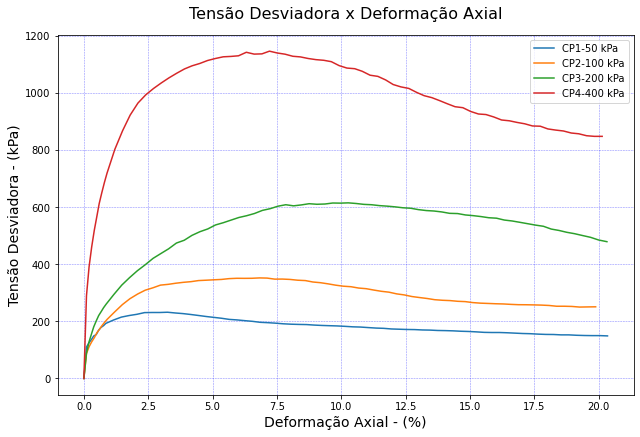

In [65]:
# Gráfico tensão desviadora x deformação axial
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,1])
eixo.plot(cp1['Deform_axial_(%)'], cp1['Sigma_d_(kPa)'],label='CP1-50 kPa')
eixo.plot(cp2['Deform_axial_(%)'], cp2['Sigma_d_(kPa)'], label='CP2-100 kPa')
eixo.plot(cp3['Deform_axial_(%)'], cp3['Sigma_d_(kPa)'], label='CP3-200 kPa')
eixo.plot(cp4['Deform_axial_(%)'], cp4['Sigma_d_(kPa)'], label='CP4-400 kPa')
eixo.legend()
eixo.set_title('Tensão Desviadora x Deformação Axial', fontsize=16, pad=16)
eixo.set_ylabel('Tensão Desviadora - (kPa)', fontsize= 14)
eixo.set_xlabel('Deformação Axial - (%)', fontsize= 14)
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)

###  Gráfico  Deformação axial x Deformação volumétrica

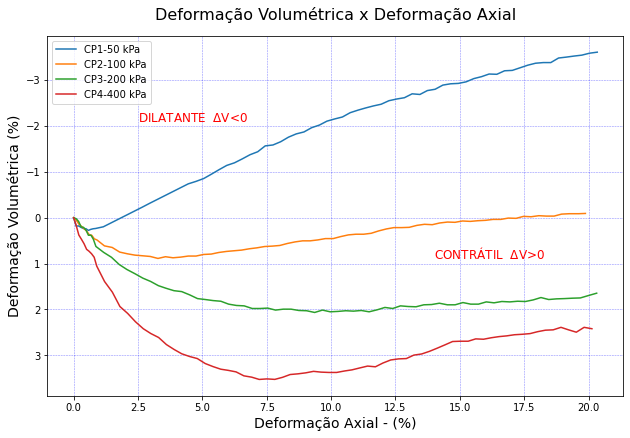

In [66]:
# Gráfico Deformação axial x deformação volumétrica
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,1])
eixo.plot(cp1['Deform_axial_(%)'], cp1['Deform_Vol_(%)'],label='CP1-50 kPa')
eixo.plot(cp2['Deform_axial_(%)'], cp2['Deform_Vol_(%)'], label='CP2-100 kPa')
eixo.plot(cp3['Deform_axial_(%)'], cp3['Deform_Vol_(%)'], label='CP3-200 kPa')
eixo.plot(cp4['Deform_axial_(%)'], cp4['Deform_Vol_(%)'], label='CP4-400 kPa')
eixo.invert_yaxis()
eixo.legend()
eixo.annotate('DILATANTE  $\Delta$V<0', color='red',xy=(2.5,-2.1), fontsize=12) 
eixo.annotate('CONTRÁTIL  $\Delta$V>0', color='red',xy=(14,0.9), fontsize=12)
eixo.set_title('Deformação Volumétrica x Deformação Axial', fontsize=16, pad=16)
eixo.set_ylabel('Deformação Volumétrica (%)', fontsize= 14)
eixo.set_xlabel('Deformação Axial - (%)', fontsize= 14)
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)


###   Trajetórias de Tensões e Parâmetros de Resistência - Máxima Tensão de Desvio

In [99]:
siglas = ['CP1 - 50 kPa','CP2-100 kPa','CP3-200 kPa','CP4-400 kPa']
Sigma_d_max = cp1['Sigma_d_(kPa)'].max()
data = {'Sigma_d_max': [cp1['Sigma_d_(kPa)'].max(),cp2['Sigma_d_(kPa)'].max(),cp3['Sigma_d_(kPa)'].max(),cp4['Sigma_d_(kPa)'].max()],
                       't': [cp1.loc[cp1['Sigma_d_(kPa)'].idxmax(), ['t'][0]],
                             cp2.loc[cp2['Sigma_d_(kPa)'].idxmax(), ['t'][0]],
                             cp3.loc[cp3['Sigma_d_(kPa)'].idxmax(), ['t'][0]],
                             cp4.loc[cp4['Sigma_d_(kPa)'].idxmax(), ['t'][0]]],
                       's': [cp1.loc[cp1['Sigma_d_(kPa)'].idxmax(), ['s'][0]],
                             cp2.loc[cp2['Sigma_d_(kPa)'].idxmax(), ['s'][0]],
                             cp3.loc[cp3['Sigma_d_(kPa)'].idxmax(), ['s'][0]],
                             cp4.loc[cp4['Sigma_d_(kPa)'].idxmax(), ['s'][0]]],
                       "s'":[cp1.loc[cp1['Sigma_d_(kPa)'].idxmax(), ["s'"][0]],
                             cp2.loc[cp2['Sigma_d_(kPa)'].idxmax(), ["s'"][0]],
                             cp3.loc[cp3['Sigma_d_(kPa)'].idxmax(), ["s'"][0]],
                             cp4.loc[cp4['Sigma_d_(kPa)'].idxmax(), ["s'"][0]]]}
                           
sigma_d_max = pd.DataFrame(data, index=siglas)

In [100]:
sigma_d_max

,Sigma_d_max,t,s,s'
CP1 - 50 kPa,231.900,115.9500,165.9500,165.9500
CP2-100 kPa,352.100,176.0500,276.0500,276.0500
CP3-200 kPa,615.033,307.5165,507.5165,507.5165
CP4-400 kPa,1146.400,573.2000,973.2000,973.2000


#### Envoltória de Tensões - Máxima Tensão de Desvio

Determinação da Envoltória (Regressão Linear Simples)

Utilizando a biblioteca estatística Statsmodels 

In [101]:
import statsmodels.api as sm

In [102]:
t = sigma_d_max['t']
s_linha = sm.add_constant(sigma_d_max["s'"])

D:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [72]:
t

CP1-50 kPa     115.9500
CP2-100 kPa    176.0500
CP3-200 kPa    307.5165
CP4-400 kPa    573.2000
Name: t, dtype: float64

In [103]:
s_linha

,const,s'
CP1 - 50 kPa,1.0,165.9500
CP2-100 kPa,1.0,276.0500
CP3-200 kPa,1.0,507.5165
CP4-400 kPa,1.0,973.2000


Calculando a envoltória

In [104]:
envoltoria_regressao = sm.OLS(t,s_linha,missing='drop').fit()

Parâmetros da envoltória de regressão

Intercepto `(a)` e declividade da envoltoria `tan_alpha`

In [105]:
a = envoltoria_regressao.params[0]
a

20.39288955489468

In [76]:
tan_alpha = envoltoria_regressao.params[1]
tan_alpha

0.5675017309002243

#### Coeficiente de determinação (R²)

In [77]:
R_2 = envoltoria_regressao.rsquared
print(f'O coeficiente de determinação R_2 = {R_2:.3f}')

O coeficiente de determinação R_2 = 1.000


In [78]:
# Intervalo de confiança
# 0 -> é o limite inferior do intervalo 
# 1 -> é o limite superior do intervalo.

envoltoria_regressao.conf_int(alpha=0.05) 

,0,1
const,14.799350,25.986429
s',0.557722,0.577282


In [79]:
# Envoltória de Regressão

#t = 7.349867 +  0.623791 * s_linha

sigma_d_max['t_Previsto'] = envoltoria_regressao.predict()

In [80]:
sigma_d_max

,Sigma_d_max,t,s,s',t_Previsto
CP1-50 kPa,231.900,115.9500,165.9500,165.9500,114.569802
CP2-100 kPa,352.100,176.0500,276.0500,276.0500,177.051742
CP3-200 kPa,615.033,307.5165,507.5165,507.5165,308.409382
CP4-400 kPa,1146.400,573.2000,973.2000,973.2000,572.685574


#### Parâmetros de Resistência - Máxima Tensão Desviadora

In [81]:
parametros_sigma_d_max =  {'tan_alpha': [tan_alpha],'sen_phi_linha':[tan_alpha],'phi_linha': [np.arcsin(tan_alpha)*(180/(np.pi))],'cos_phi_linha': [np.cos(np.arcsin(tan_alpha)*(180/(np.pi))*(np.pi/180))],'a': a, "c": a/[np.cos(np.arcsin(tan_alpha)*(180/(np.pi))*(np.pi/180))]}

parametros_max_desvio = pd.DataFrame(parametros_sigma_d_max).round(1)
parametros_max_desvio

,tan_alpha,sen_phi_linha,phi_linha,cos_phi_linha,a,c
0,0.6,0.6,34.6,0.8,20.4,24.8


In [82]:
parametros_max_desvio.rename(index={0:'Parâmetros de Resistência'}, inplace=True)
parametros_max_desvio.T

,Parâmetros de Resistência
tan_alpha,0.6
sen_phi_linha,0.6
phi_linha,34.6
cos_phi_linha,0.8
a,20.4
c,24.8


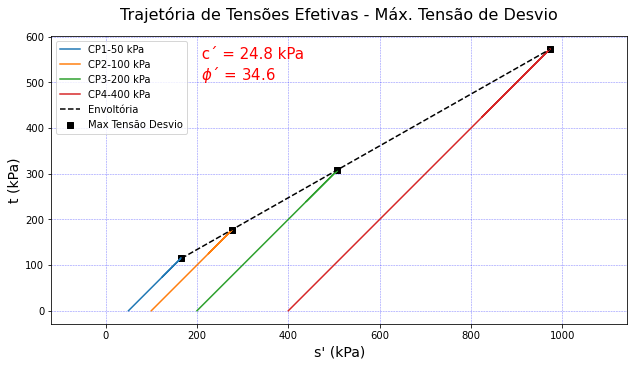

In [83]:
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,0.8])

c, phi_linha = parametros_max_desvio['c'], parametros_max_desvio['phi_linha']

eixo.plot(cp1["s'"], cp1["t"],label='CP1-50 kPa')
eixo.plot(cp2["s'"], cp2['t'], label='CP2-100 kPa')
eixo.plot(cp3["s'"], cp3['t'], label='CP3-200 kPa')
eixo.plot(cp4["s'"], cp4['t'], label='CP4-400 kPa')
plt.scatter(sigma_d_max["s'"],sigma_d_max['t'], label='Max Tensão Desvio', marker='s', s=40, color='k')
eixo.plot(sigma_d_max["s'"],sigma_d_max['t_Previsto'],label='Envoltória', color='k', ls='--')

eixo.annotate(f' c´ = {c[0]} kPa\n $\phi´$ = {phi_linha[0]}', xy=(200,505), color='red', fontsize=15)                                                    
eixo.set_title('Trajetória de Tensões Efetivas - Máx. Tensão de Desvio', fontsize=16, pad=16)
eixo.set_ylabel('t (kPa)', fontsize= 14)
eixo.set_xlabel("s' (kPa)", fontsize= 14)
plt.legend(loc='best')
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.axis('equal')
xticks = [0,100,200,300,400,500,600,700,800,900,1000,1100]
yticks = [0,100,200,300,400,500,600,700]
plt.show()

### CÍRCULO DE MOHR

#### Selecionando  a linha de Máxima Tensão Desviadora para cada cp

In [84]:
a = cp1[cp1["Sigma_d_(kPa)"] == cp1["Sigma_d_(kPa)"].max()]

In [85]:
a

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
17,3.249521,-0.397188,231.9,50,281.9,281.9,50,5.64,115.95,165.95,165.95,231.9,127.3,127.3


In [86]:
b = cp2[cp2["Sigma_d_(kPa)"] == cp2["Sigma_d_(kPa)"].max()]

In [87]:
b

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
29,6.823889,0.67775,352.1,100,452.1,452.1,100,4.52,176.05,276.05,276.05,352.1,217.366667,217.366667


In [88]:
c = cp3[cp3["Sigma_d_(kPa)"] == cp3["Sigma_d_(kPa)"].max()]

In [89]:
c

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
40,10.268938,2.042661,615.033,200,815.033,815.033,200,4.08,307.5165,507.5165,507.5165,615.033,405.011,405.011


In [90]:
d = cp4[cp4["Sigma_d_(kPa)"] == cp4["Sigma_d_(kPa)"].max()]

In [91]:
d

,Deform_axial_(%),Deform_Vol_(%),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
30,7.208577,3.525412,1146.4,400,1546.4,1546.4,400,3.87,573.2,973.2,973.2,1146.4,782.133333,782.133333


In [92]:
siglas = ['CP1 - 50 kPa','CP2-100 kPa','CP3-200 kPa','CP4-400 kPa']
data = {'sig_1': [a["Sigma'_1_(kPa)"].max(),b["Sigma'_1_(kPa)"].max(),c["Sigma'_1_(kPa)"].max(),d["Sigma'_1_(kPa)"].max()],
        'sig_3': [a["Sigma3'_(kPa)"].max(),b["Sigma3'_(kPa)"].max(),c["Sigma3'_(kPa)"].max(),d["Sigma3'_(kPa)"].max()]}
circulos = pd.DataFrame(data=data, index=siglas)    

circulos['Raio_(i)'] = (circulos['sig_1'] - circulos['sig_3'])/2
circulos['Centro_(x_i)'] = (circulos['sig_1'] + circulos['sig_3'])/2

In [93]:
circulos

,sig_1,sig_3,Raio_(i),Centro_(x_i)
CP1 - 50 kPa,281.900,50,115.9500,165.9500
CP2-100 kPa,452.100,100,176.0500,276.0500
CP3-200 kPa,815.033,200,307.5165,507.5165
CP4-400 kPa,1546.400,400,573.2000,973.2000


#### Traçado da Envoltória de Mohr-Coulomb

Para o traçado da envoltória forneça os valores de  `c (coesão) e phi (ângulo de atrito)` até ajustar a envoltória 
aos círculos de Mohr.

Forneça também o valor de `sig` para ajustar a envoltória no intervalo de tensões do ensaio.

Valores de c e sig em kPa e phi em graus.

In [123]:
c = 24.8
phi =  34.6
sig = 900

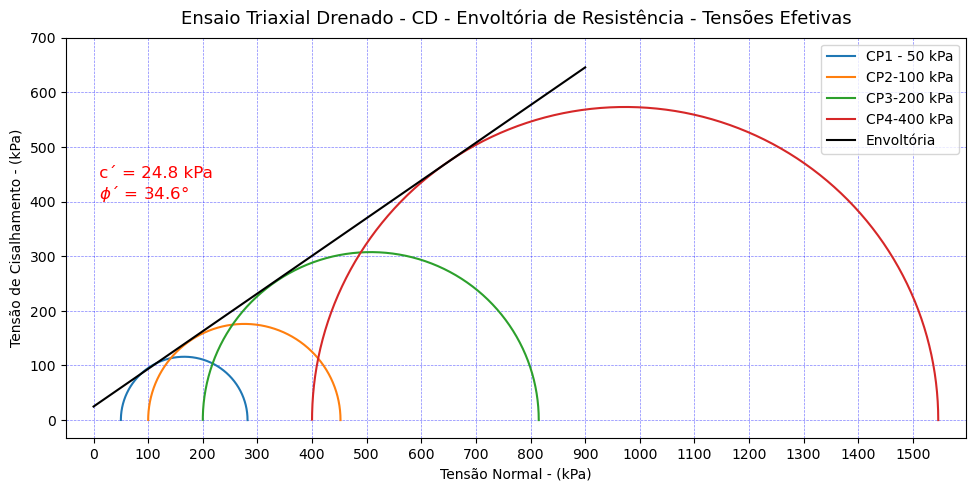

In [124]:
fig = plt.figure(figsize=(15,8), dpi=100)
ax = fig.add_axes([0,0.1,0.6,0.5])

#PARÂMETROS DO CÍRCULOS
x0, r = circulos['Centro_(x_i)'].loc['CP1 - 50 kPa'],circulos['Raio_(i)'].loc['CP1 - 50 kPa']
x1, r1 = circulos['Centro_(x_i)'].loc['CP2-100 kPa'],circulos['Raio_(i)'].loc['CP2-100 kPa']
x2, r2 = circulos['Centro_(x_i)'].loc['CP3-200 kPa'],circulos['Raio_(i)'].loc['CP3-200 kPa']
x3, r3 = circulos['Centro_(x_i)'].loc['CP4-400 kPa'],circulos['Raio_(i)'].loc['CP4-400 kPa']

#EQUAÇÕES PARAMÉTRICAS DO CÍRCULO
t = np.arange(0,np.pi, 0.01)
x = x0 + r * np.cos(t)
y = r * np.sin(t)
x1 = x1 + r1 * np.cos(t)
y1 = r1 * np.sin(t)
x2 = x2 + r2 * np.cos(t)
y2 = r2 * np.sin(t)
x3 = x3 + r3 * np.cos(t)
y3 = r3 * np.sin(t)

#PLOTAGEM DOS CÍRCULOS
ax.plot(x,y, label='CP1 - 50 kPa')
ax.plot(x1,y1, label='CP2-100 kPa')
ax.plot(x2,y2, label='CP3-200 kPa')
ax.plot(x3,y3, label='CP4-400 kPa')

# CALCULANDO A ENVOLTÓRIA DE TENSÕES
c = c
phi = phi*(np.pi/180)
sig = sig
tau = c + sig * np.tan(phi)
#x3= [0,sig]
x4= [0,sig]
y4= [c,tau]
ax.plot(x4,y4,'k-', label="Envoltória")

#ADICIONANDO LEGENDA, GRID E AJUSTANDO ESCALAS IGUAIS NOS EIXOS X e Y
ax.legend(loc='best')
plt.axis('equal')
xticks = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600]
yticks = [0,100,200,300,400,500,600,700]
ax.set_xticks(xticks)
ax.set_yticks(yticks)
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)

#ADICIONANDO TEXTO 
#ax.plot(c', phi)
#ax.text(0,90, r'c = 17 kPa', fontsize=12,color="black")
#ax.text(0,80, r'$\phi$ = 35°', fontsize=12, color="black")
ax.annotate(f' c´ = {c} kPa\n $\phi´$ = {phi*180/np.pi:.1f}°', xy=(0,405), color='red', fontsize=12)   

#ADICIONANDO TÍTULOS DO GRÁFICO E DOS EIXOS
ax.set_xlabel('Tensão Normal - (kPa)')
ax.set_ylabel('Tensão de Cisalhamento - (kPa)')
ax.set_title('Ensaio Triaxial Drenado - CD - Envoltória de Resistência - Tensões Efetivas', fontsize=13, pad=10)
plt.show()